## Grading Student Essays

In this notebook, I finetune a sequence classifier model from Hugging Face using the [Hewlett Foundation scored essay data set](https://www.kaggle.com/competitions/asap-aes/data).  
This dataset is taken from the training_set_rel3.xlsx on Kaggle. 
The problem is treated as a regression problem to account for continuous scoring.

### 1 - Install and load required dependencies 

In [2]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    loralib==0.1.1 --quiet

%pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import mean_squared_error

## 2 - Define a DataSet Class

In [4]:
model_name = 'bert-base-uncased'

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, essays, grades):
        self.essays = essays
        self.grades = grades
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        essay = self.essays[idx]
        grade = self.grades[idx]
        tokens = self.tokenizer(essay, truncation=True, padding='max_length', max_length=512)
        return {key: torch.tensor(val, dtype=torch.long) for key, val in tokens.items()}, torch.tensor(grade, dtype=torch.float)


### 3 - Load data

In [5]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='scored_essays.csv')
print(dataset)

Found cached dataset csv (/root/.cache/huggingface/datasets/csv/default-38362ed01254b30c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'essay', 'domain1_score'],
        num_rows: 12978
    })
})


#### 3.1 - Shuffle and sample a smaller dataset

In [6]:
# Shuffle the dataset
shuffled_dataset = dataset['train'].shuffle(seed=42)

# Select n random samples
n_samples = 2000
scored_essays = shuffled_dataset.select(range(n_samples))

print(scored_essays)


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-38362ed01254b30c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-c6ce648331b3305d.arrow


Dataset({
    features: ['essay_id', 'essay', 'domain1_score'],
    num_rows: 2000
})


#### 3.2 - Extract the essays and grades

In [7]:
essays = scored_essays['essay'] # list of essay strings
grades = scored_essays['domain1_score'] # list of numerical grades

Split the data

In [8]:
from sklearn.model_selection import train_test_split

# Split into training and temporary sets (80/20 split)
essays_train, essays_temp, grades_train, grades_temp = train_test_split(
    essays, grades, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50/50 split)
essays_val, essays_test, grades_val, grades_test = train_test_split(
    essays_temp, grades_temp, test_size=0.5, random_state=42)


#### 3.3 Scale the grades  
QuantileTransformer: This scaler transforms the features to follow a uniform or a normal distribution.  
Therefore, for a given feature, this transformation tends to spread out the most frequent values and reduces the impact of (marginal) outliers.

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

# Convert grades_train, grades_val, and grades_test lists to numpy arrays
grades_train = np.array(grades_train).reshape(-1,1)
grades_val = np.array(grades_val).reshape(-1,1)
grades_test = np.array(grades_test).reshape(-1,1)

# Quantile Transformer
quantile_transformer = QuantileTransformer(output_distribution='normal')
grades_train_scaled = quantile_transformer.fit_transform(grades_train)
grades_val_scaled = quantile_transformer.fit_transform(grades_val)
grades_test_scaled = quantile_transformer.fit_transform(grades_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


### 4 - Tokenize the data  
Create a dataset where each item is a tuple containing the tokenized essay and the corresponding numerical grade.  
These datasets can then be used to create DataLoaders which will handle batching of data for training.

In [10]:
train_dataset = EssayDataset(essays_train, grades_train_scaled)
val_dataset = EssayDataset(essays_val, grades_val_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#### 4.1 - Initialize the original model and tokenizer

In [11]:
original_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)  # For regression
optimizer = AdamW(original_model.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### 4.2 - Print the number of trainable model parameters

In [12]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 109483009
all model parameters: 109483009
percentage of trainable model parameters: 100.00%


### 5 - Full fine tuning


Train for one epoch initially to be sure the training and validation steps work.  

In [ ]:
n_epochs = 1  # Number of training epochs

for epoch in range(n_epochs):
    # Training
    original_model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        # Unpack the tokenized tensors and grades from the batch
        tokenized_tensors = batch[0]
        grade = batch[1]
        
        # Extract the tokenized tensors
        input_ids = tokenized_tensors['input_ids']
        attention_mask = tokenized_tensors['attention_mask']
        
        # Forward pass
        outputs = original_model(input_ids=input_ids, attention_mask=attention_mask, labels=grade)
        loss = outputs.loss
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training loss: {train_loss / len(train_dataloader)}')
    

   # Validation
    original_model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            # Directly unpack the batch
            tokenized_tensors = batch[0]
            grades = batch[1]
        
            input_ids = tokenized_tensors['input_ids']
            attention_mask = tokenized_tensors['attention_mask']
            labels = grade

            # Forward pass
            outputs = original_model(input_ids=input_ids, attention_mask=attention_mask)
            val_preds.extend(outputs.logits.squeeze().tolist())
            val_labels.extend(labels.tolist())

    val_mse = mean_squared_error(val_labels, val_preds)
    print(f'Validation MSE: {val_mse}')


Modify code to include early stopping criteria

In [ ]:
import copy

n_epochs = 20  # Make this a high number to benefit from early stopping
patience = 5  # How many epochs to wait after last time validation loss improved.
patience_counter = 0  # Counter for early stopping
best_val_loss = float('inf')
best_model = None

for epoch in range(n_epochs):
    # Training
    original_model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        # Unpack the tokenized tensors and grades from the batch
        tokenized_tensors = batch[0]
        grade = batch[1]
        
        # Extract the tokenized tensors
        input_ids = tokenized_tensors['input_ids']
        attention_mask = tokenized_tensors['attention_mask']
        
        # Forward pass
        outputs = original_model(input_ids=input_ids, attention_mask=attention_mask, labels=grade)
        loss = outputs.loss
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training loss: {train_loss / len(train_dataloader)}')
    

   # Validation
    original_model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            # Directly unpack the batch
            tokenized_tensors = batch[0]
            grade = batch[1]
        
            input_ids = tokenized_tensors['input_ids']
            attention_mask = tokenized_tensors['attention_mask']
            labels = grade

            # Forward pass
            outputs = original_model(input_ids=input_ids, attention_mask=attention_mask)
            val_preds.extend(outputs.logits.squeeze().tolist())
            val_labels.extend(labels.tolist())

    val_mse = mean_squared_error(val_labels, val_preds)
    print(f'Validation MSE: {val_mse}')
    
    # Check if validation loss improved
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        best_model = copy.deepcopy(original_model.state_dict())
        patience_counter = 0
        print(f'Validation MSE improved to {val_mse}. Saving model!')
    else:
        patience_counter += 1
        print(f'Validation MSE did not improve. Patience: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Stopping early after {patience_counter} epochs without improvement.')
        break


Save the best model and the corresponding tokenizer

In [ ]:
model_path = './full-finetune-essay-score-training'

# Ensure the best model weights are loaded
original_model.load_state_dict(best_model)

# Save model weights
original_model.save_pretrained(model_path)

# Save tokenizer from the train_dataset
train_dataset.tokenizer.save_pretrained(model_path)


Optional: Reload model and tokenizer from file when needed

In [ ]:
original_model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

### 6 - Parameter efficient fine tuning

#### 6.1 - Setup the PEFT/LoRA model for Fine-Tuning

Performing full-finetuning can lead to catastrophic forgetting because it changes all parameters on the model. Since PEFT only updates a small subset of parameters, it's more robust against this catastrophic forgetting effect.

Set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [13]:
%pip install peft==0.3.0 --quiet

from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    target_modules=["attention.self.query", "attention.self.value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS # Sequence classificatio task
)


Note: you may need to restart the kernel to use updated packages.


#### 6.2 - Add LoRA adapter layers/parameters to the original LLM to be trained.

In [14]:
peft_model = get_peft_model(original_model, lora_config)

print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 1181186
all model parameters: 110663426
percentage of trainable model parameters: 1.07%


#### 6.3 - Train PEFT Adapter

Define training arguments and create `Trainer` instance.

In [15]:
import copy

n_epochs = 20  # Make this a high number to benefit from early stopping
patience = 5  # How many epochs to wait after last time validation loss improved.
patience_counter = 0  # Counter for early stopping
best_val_loss = float('inf')
best_model = None

optimizer = AdamW(peft_model.parameters(), lr=1e-3) # Higher learning rate than full fine tuning

peft_model_path = './peft-finetune-essay-score-training'

for epoch in range(n_epochs):
    # Training
    peft_model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        # Unpack the tokenized tensors and grades from the batch
        tokenized_tensors = batch[0]
        grade = batch[1]
        
        # Extract the tokenized tensors
        input_ids = tokenized_tensors['input_ids']
        attention_mask = tokenized_tensors['attention_mask']
        
        # Forward pass
        outputs = peft_model(input_ids=input_ids, attention_mask=attention_mask, labels=grade)
        loss = outputs.loss
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training loss: {train_loss / len(train_dataloader)}')
    

   # Validation
    peft_model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            # Directly unpack the batch
            tokenized_tensors = batch[0]
            grade = batch[1]
        
            input_ids = tokenized_tensors['input_ids']
            attention_mask = tokenized_tensors['attention_mask']
            labels = grade

            # Forward pass
            outputs = peft_model(input_ids=input_ids, attention_mask=attention_mask)
            val_preds.extend(outputs.logits.squeeze().tolist())
            val_labels.extend(labels.tolist())

    val_mse = mean_squared_error(val_labels, val_preds)
    print(f'Validation MSE: {val_mse}')
    
    # Check if validation loss improved
    if val_mse < best_val_loss:
        best_val_loss = val_mse
        best_model = copy.deepcopy(peft_model.state_dict())
        patience_counter = 0
        print(f'Validation MSE improved to {val_mse}. Saving model!')
        
        # Save best model to disk
        # First ensure the best model weights are loaded
        peft_model.load_state_dict(best_model)

        # Save model weights
        peft_model.save_pretrained(peft_model_path)

        # Save tokenizer from the train_dataset
        train_dataset.tokenizer.save_pretrained(peft_model_path)
    else:
        patience_counter += 1
        print(f'Validation MSE did not improve. Patience: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Stopping early after {patience_counter} epochs without improvement.')
        break


Epoch 1, Training loss: 0.9469961788132787
Validation MSE: 0.7365528004692424
Validation MSE improved to 0.7365528004692424. Saving model!
Epoch 2, Training loss: 0.6022367420792579
Validation MSE: 0.6282056848808154
Validation MSE improved to 0.6282056848808154. Saving model!
Epoch 3, Training loss: 0.4471785858646035
Validation MSE: 0.654266343730865
Validation MSE did not improve. Patience: 1/5
Epoch 4, Training loss: 0.4250129825156182
Validation MSE: 0.7791248460339716
Validation MSE did not improve. Patience: 2/5
Epoch 5, Training loss: 0.5221770444791765
Validation MSE: 0.7224576622965544
Validation MSE did not improve. Patience: 3/5
Epoch 6, Training loss: 0.3821337918192148
Validation MSE: 0.7441996288568903
Validation MSE did not improve. Patience: 4/5
Epoch 7, Training loss: 0.34620294894091785
Validation MSE: 0.7106972401324078
Validation MSE did not improve. Patience: 5/5
Stopping early after 5 epochs without improvement.


#### 6.4 - Save the final best model and the corresponding tokenizer 

In [18]:
peft_model_path = './peft-finetune-essay-score-training'

# Ensure the best model weights are loaded
peft_model.load_state_dict(best_model)

# Save model weights
peft_model.save_pretrained(peft_model_path)

# Save tokenizer from the train_dataset
train_dataset.tokenizer.save_pretrained(peft_model_path)


('./peft-finetune-essay-score-training/tokenizer_config.json',
 './peft-finetune-essay-score-training/special_tokens_map.json',
 './peft-finetune-essay-score-training/vocab.txt',
 './peft-finetune-essay-score-training/added_tokens.json')

#### 6.5 - Prepare this model by adding an adapter to the original model.   
Set is_trainable=False because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set is_trainable=True.

In [19]:
from peft import PeftModel, PeftConfig

peft_model_base = BertForSequenceClassification.from_pretrained(model_name, num_labels=1, torch_dtype=torch.bfloat16)
tokenizer = BertTokenizer.from_pretrained(model_name)

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       peft_model_path, 
                                       torch_dtype=torch.bfloat16,
                                       num_labels=1,
                                       is_trainable=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### 7 - Inference 

#### 7.1 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences with the original model and PEFT model for one test instance initially.  
Please note the original model would normally be the fully fine tuned model.  
I have not fine tuned the original model fully to conserve resources.

In [20]:
index = 12

essay = essays_test[index]
scaled_score = grades_test_scaled[index]

# Prepare the prompt and tokenize
prompt = f"Assign a score to the following essay:\n\n{essay}\n\nScore:"
inputs = tokenizer(prompt, return_tensors="pt")

# Move tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Make sure your models are in evaluation mode
original_model.eval()
peft_model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get model predictions
    original_model_outputs = original_model(**inputs)
    peft_model_outputs = peft_model(**inputs)

    # Extract the score from the outputs (assuming a single regression output)
    original_model_score = original_model_outputs.logits.squeeze().item()
    peft_model_score = peft_model_outputs.logits.squeeze().item()
    
    # Scale the grades back to their original values
    original_model_score = quantile_transformer.inverse_transform(np.array(original_model_score).reshape(-1,1))
    y_pred_original = quantile_transformer.inverse_transform(np.array(peft_model_score).reshape(-1,1))
    y_test_original = quantile_transformer.inverse_transform(np.array(scaled_score).reshape(-1,1))


# Print results
print(f"BASELINE HUMAN SCORE: {y_test_original[0][0]:.1f}")
print(f"ORIGINAL MODEL SCORE: {original_model_score[0][0]:.1f}") #This would normally be the score from the fully fine tined model
print(f"PEFT MODEL SCORE: {y_pred_original[0][0]:.1f}")


BASELINE HUMAN SCORE: 1.0
ORIGINAL MODEL SCORE: 1.0
PEFT MODEL SCORE: 1.0


#### 7.2 - Evaluate the performance on the test set

For regression tasks, the concept of an error percentage is not as straightforward as in classification tasks because the range of possible values is not bounded between 0 and 1. However, there are relative error metrics that can provide a sense of the error relative to the magnitude of the values being predicted. One such metric is the Mean Absolute Percentage Error (MAPE).

MAPE measures the size of the error in percentage terms. It is calculated as the average of the absolute percentage errors of the predictions.  

MAPE has some drawbacks, though:

It can be undefined if any y true values are or close to zero.  
It puts a heavier penalty on negative errors than positive ones in certain contexts.

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


n=10 # print progress every nth batch
y_test = []
y_pred = []
max_length = 512  # Maximum length for BERT-based models

for index in range(len(essays_test)):
#for index in range(30,35): # skip long essays that are longer than the token limit
    
    essay = essays_test[index]
    scaled_score = grades_test_scaled[index]
    
    prompt = f"""
    Assign a score to the following essay.
    
    {essay}
    
    Score:
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Check the length of the tokenized essay
    input_length = inputs.input_ids.size(1)
    if input_length > max_length:
        print(f"Skipping essay {index} with length {input_length}...")
        continue
    
    # Move tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make sure your models are in evaluation mode
    original_model.eval()
    peft_model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get model predictions
        peft_model_outputs = peft_model(**inputs)
        peft_model_score = peft_model_outputs.logits.squeeze().item()

        y_pred.append(peft_model_score)
        y_test.append(scaled_score)
    
    # Print progress message every nth iteration
    if index % n == 0:
        print(f"Processing batch {index}/{len(essays_test)}")    
        
# Scale the grades back to their original values
y_pred_original = quantile_transformer.inverse_transform(np.array(y_pred).reshape(-1,1))
y_test_original = quantile_transformer.inverse_transform(np.array(y_test).reshape(-1,1))

# Calculate MSE, MAE, MAPE
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print("\n")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Processing batch 0/200


Token indices sequence length is longer than the specified maximum sequence length for this model (766 > 512). Running this sequence through the model will result in indexing errors


Skipping essay 5 with length 766...
Processing batch 10/200
Skipping essay 11 with length 834...
Skipping essay 20 with length 720...
Processing batch 30/200
Skipping essay 37 with length 624...
Processing batch 40/200
Skipping essay 42 with length 861...
Skipping essay 45 with length 576...
Skipping essay 49 with length 595...
Processing batch 50/200
Skipping essay 55 with length 570...
Skipping essay 57 with length 626...
Processing batch 60/200
Skipping essay 66 with length 776...
Processing batch 70/200
Skipping essay 71 with length 669...
Skipping essay 75 with length 539...
Skipping essay 76 with length 627...
Skipping essay 79 with length 611...
Processing batch 80/200
Skipping essay 83 with length 695...
Skipping essay 87 with length 996...
Skipping essay 89 with length 747...
Processing batch 90/200
Skipping essay 93 with length 525...
Skipping essay 98 with length 777...
Processing batch 100/200
Skipping essay 105 with length 588...
Skipping essay 109 with length 840...
Proce

/tmp/ipykernel_2984/2160044727.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#### 7.3 Plot results

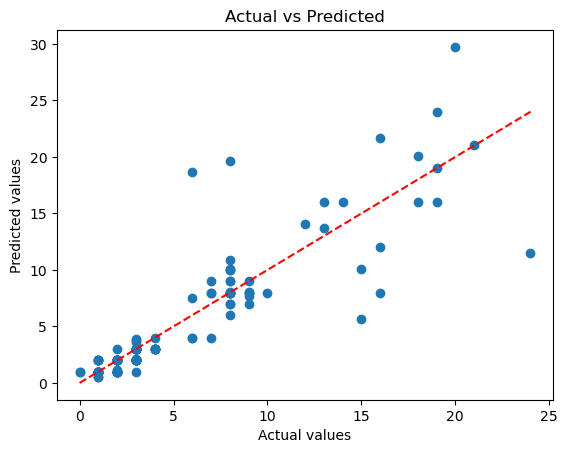

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_pred_original)
plt.title('Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.show()